In [1]:
%matplotlib notebook

import pandas as pd
import matplotlib.pyplot as plt

In [66]:
# Clean data
df_approved = pd.read_csv('./approved.csv')
df_rejected = pd.read_csv('./rejected.csv')

# Encode state
df_approved['is_approved'] = pd.Series([1, ] * len(df_approved))
df_rejected['is_approved'] = pd.Series([0, ] * len(df_approved))
df = pd.concat([df_approved, df_rejected])

In [72]:
# Drop not convertable to float strings
df = df[
    (pd.to_numeric(df.payments_out_amount_average, errors='coerce').notnull()) &\
    (pd.to_numeric(df.payments_out_amount_total, errors='coerce').notnull()) &\
    (pd.to_numeric(df.payments_out_count, errors='coerce').notnull()) &\
    (pd.to_numeric(df.payments_out_std_dev, errors='coerce').notnull()) &\
    (pd.to_numeric(df.uploads_amount_average, errors='coerce').notnull()) &\
    (pd.to_numeric(df.uploads_amount_total, errors='coerce').notnull()) &\
    (pd.to_numeric(df.uploads_count, errors='coerce').notnull()) &\
    (pd.to_numeric(df.uploads_std_dev, errors='coerce').notnull())]

In [73]:
# Convert all numeric features to float
for feature in [
        'payments_out_amount_average',
        'payments_out_amount_total',
        'payments_out_count',
        'payments_out_std_dev',
        'uploads_amount_average',
        'uploads_amount_total',
        'uploads_count',
        'uploads_std_dev']:
    df[feature] = pd.to_numeric(df[feature])

In [74]:
# Convert boolean feature
df['registration_ip_mathes_domicile'] = \
    df.registration_ip_mathes_domicile.map(lambda x: int(x == 'true'))

In [77]:
# Describe dataset
df.describe()

,amount,payments_out_amount_average,payments_out_amount_total,payments_out_count,payments_out_std_dev,uploads_amount_average,uploads_amount_total,uploads_count,uploads_std_dev,registration_ip_mathes_domicile,is_approved
count,7384.000000,7384.000000,7.384000e+03,7384.000000,7384.000000,7384.000000,7.384000e+03,7384.000000,7384.000000,7384.000000,7384.000000
mean,790.020439,389.758766,7.666001e+04,161.154523,795.242716,1770.907291,8.437128e+04,120.353873,1847.487708,0.938109,0.982259
std,2576.223921,640.350259,2.047700e+05,237.927011,1502.646894,4220.249400,2.216740e+05,296.483639,3729.338452,0.240973,0.132018
min,0.000000,0.000000,0.000000e+00,1.000000,0.000000,0.100000,0.000000e+00,1.000000,0.000000,0.000000,0.000000
25%,52.937500,89.430728,4.409000e+03,23.000000,156.824945,172.116774,6.217000e+03,12.000000,180.822476,1.000000,1.000000
50%,180.000000,207.153199,1.677600e+04,70.000000,373.349069,500.000000,2.111950e+04,37.000000,634.851178,1.000000,1.000000
75%,578.085000,446.957189,6.403925e+04,201.000000,799.213400,1764.106500,6.953900e+04,111.000000,1948.397328,1.000000,1.000000
max,65000.000000,12800.065000,5.327272e+06,1971.000000,35675.883473,100000.000000,5.024442e+06,14562.000000,60138.728509,1.000000,1.000000


In [78]:
# Visualize distribution for non numeric or discrete features
def visualize_non_numeric_feature_distriution(
        df, feature,
    ):
    """
    Plot distribution for feature for approved and rejected payments
    """
    f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
    plt.style.use('ggplot')
    df[df.is_approved == 1][feature].\
        value_counts().plot.bar(
            ax=ax1, legend=True, 
            title='Approved')
    df[df.is_approved == 0][feature].\
        value_counts().plot.bar(
            ax=ax2, legend=True, 
            title='Rejected')
    plt.show()   

<IPython.core.display.Javascript object>


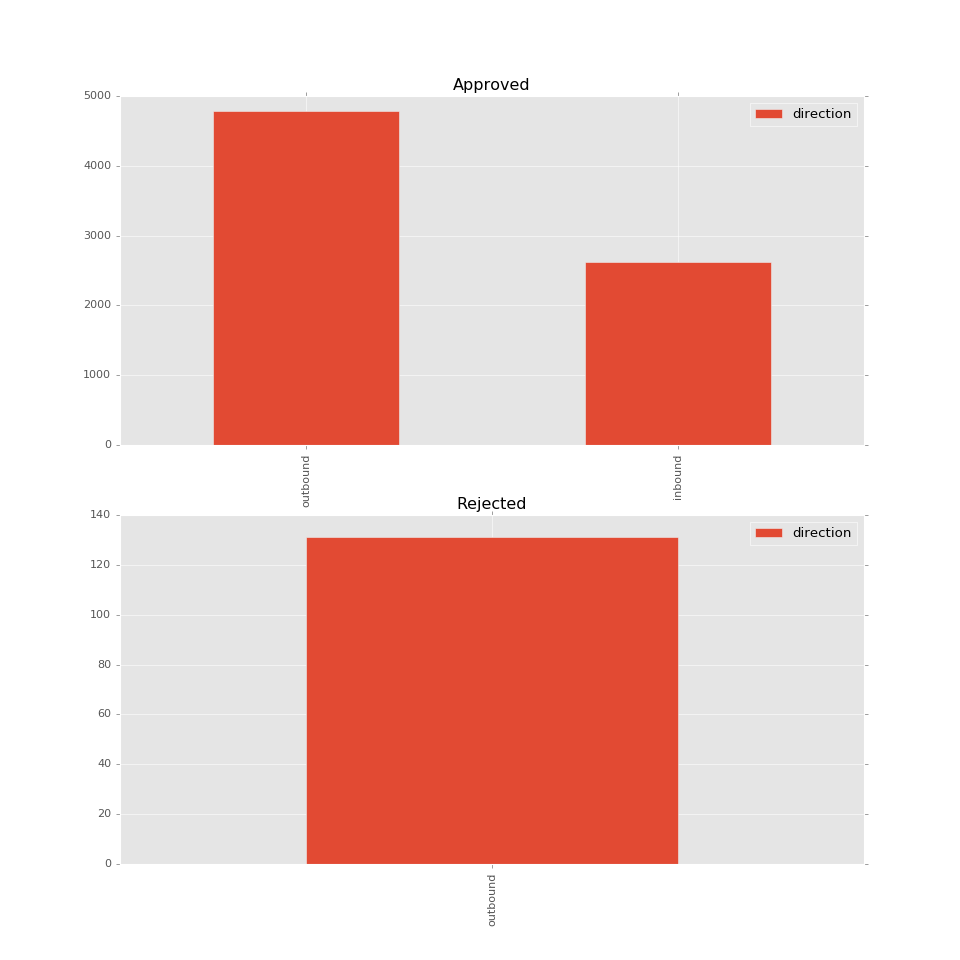

In [50]:
# Plot direction distribution
visualize_non_numeric_feature_distriution(df, 'direction') 

<IPython.core.display.Javascript object>


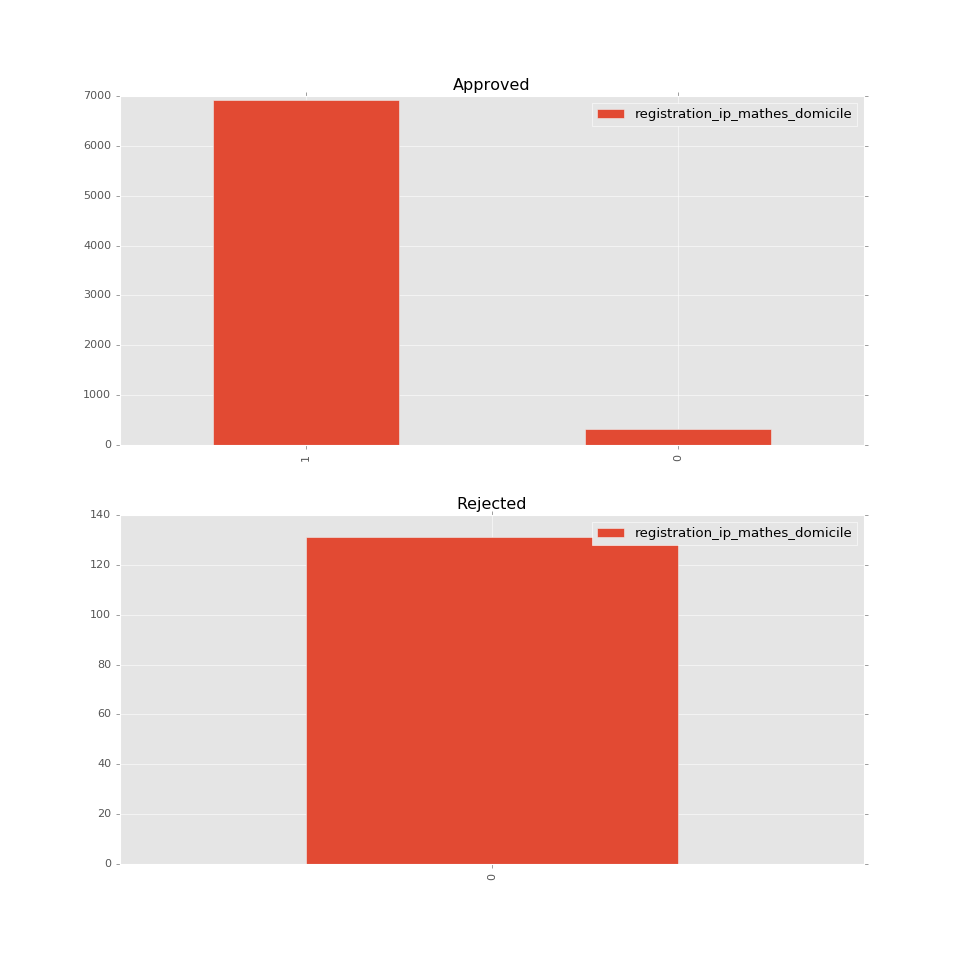

In [93]:
# Plot direction distribution
visualize_non_numeric_feature_distriution(df, 'registration_ip_mathes_domicile') 

In [79]:
# Add direction feature
df['is_outbound'] = df.direction.map(lambda x: int(x == 'outbound'))

In [80]:
# Check if currency is valuable feature
df.currency.value_counts()

EUR    7384
Name: currency, dtype: int64

In [81]:
# Remove currency from dataframe
df = df.drop('currency')

In [86]:
# Try a bit of feature mining
import math
df['diff_to_avg_amount'] = df.apply(
    lambda x: x.amount - x.payments_out_amount_average \
              if x.is_outbound else \
              x.amount - x.uploads_amount_average,
    axis=1)

df['is_outlier'] = df.apply(
    lambda x: int(x.diff_to_avg_amount > 3 * math.sqrt(x.payments_out_std_dev)) \
              if x.is_outbound else \
              int(x.diff_to_avg_amount > 3 * math.sqrt(x.uploads_std_dev)),
    axis=1)

df['difference_btw_incoming_and_outcoming_payments_number'] = df.apply(
    lambda x: x.uploads_amount_average - x.payments_out_amount_average,
    axis=1)

df['difference_btw_incoming_and_outcoming_payments_volume'] = df.apply(
    lambda x: x.uploads_amount_average - x.payments_out_amount_total,
    axis=1)

df['difference_btw_incoming_and_outcoming_payments_number'] = df.apply(
    lambda x: x.uploads_count - x.payments_out_count,
    axis=1)

In [87]:
df.describe()

,amount,payments_out_amount_average,payments_out_amount_total,payments_out_count,payments_out_std_dev,uploads_amount_average,uploads_amount_total,uploads_count,uploads_std_dev,registration_ip_mathes_domicile,is_approved,is_outbound,diff_to_avg_amount,is_outlier,differents_btw_incoming_and_outcoming_payments_number,differents_btw_incoming_and_outcoming_payments_volume,difference_btw_incoming_and_outcoming_payments_number,difference_btw_incoming_and_outcoming_payments_volume
count,7384.000000,7384.000000,7.384000e+03,7384.000000,7384.000000,7384.000000,7.384000e+03,7384.000000,7384.000000,7384.000000,7384.000000,7384.000000,7384.000000,7384.000000,7384.000000,7.384000e+03,7384.000000,7.384000e+03
mean,790.020439,389.758766,7.666001e+04,161.154523,795.242716,1770.907291,8.437128e+04,120.353873,1847.487708,0.938109,0.982259,0.665628,221.864544,0.373104,-40.800650,-7.488910e+04,-40.800650,-7.488910e+04
std,2576.223921,640.350259,2.047700e+05,237.927011,1502.646894,4220.249400,2.216740e+05,296.483639,3729.338452,0.240973,0.132018,0.471802,2401.242252,0.483662,331.678427,2.035212e+05,331.678427,2.035212e+05
min,0.000000,0.000000,0.000000e+00,1.000000,0.000000,0.100000,0.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000,-19610.303333,0.000000,-1929.000000,-5.326378e+06,-1929.000000,-5.326378e+06
25%,52.937500,89.430728,4.409000e+03,23.000000,156.824945,172.116774,6.217000e+03,12.000000,180.822476,1.000000,1.000000,0.000000,-181.440230,0.000000,-96.000000,-6.188431e+04,-96.000000,-6.188431e+04
50%,180.000000,207.153199,1.677600e+04,70.000000,373.349069,500.000000,2.111950e+04,37.000000,634.851178,1.000000,1.000000,1.000000,-16.162534,0.000000,-17.000000,-1.549957e+04,-17.000000,-1.549957e+04
75%,578.085000,446.957189,6.403925e+04,201.000000,799.213400,1764.106500,6.953900e+04,111.000000,1948.397328,1.000000,1.000000,1.000000,197.073586,1.000000,9.000000,-3.679507e+03,9.000000,-3.679507e+03
max,65000.000000,12800.065000,5.327272e+06,1971.000000,35675.883473,100000.000000,5.024442e+06,14562.000000,60138.728509,1.000000,1.000000,1.000000,63581.229161,1.000000,14412.000000,7.683600e+04,14412.000000,7.683600e+04


<IPython.core.display.Javascript object>


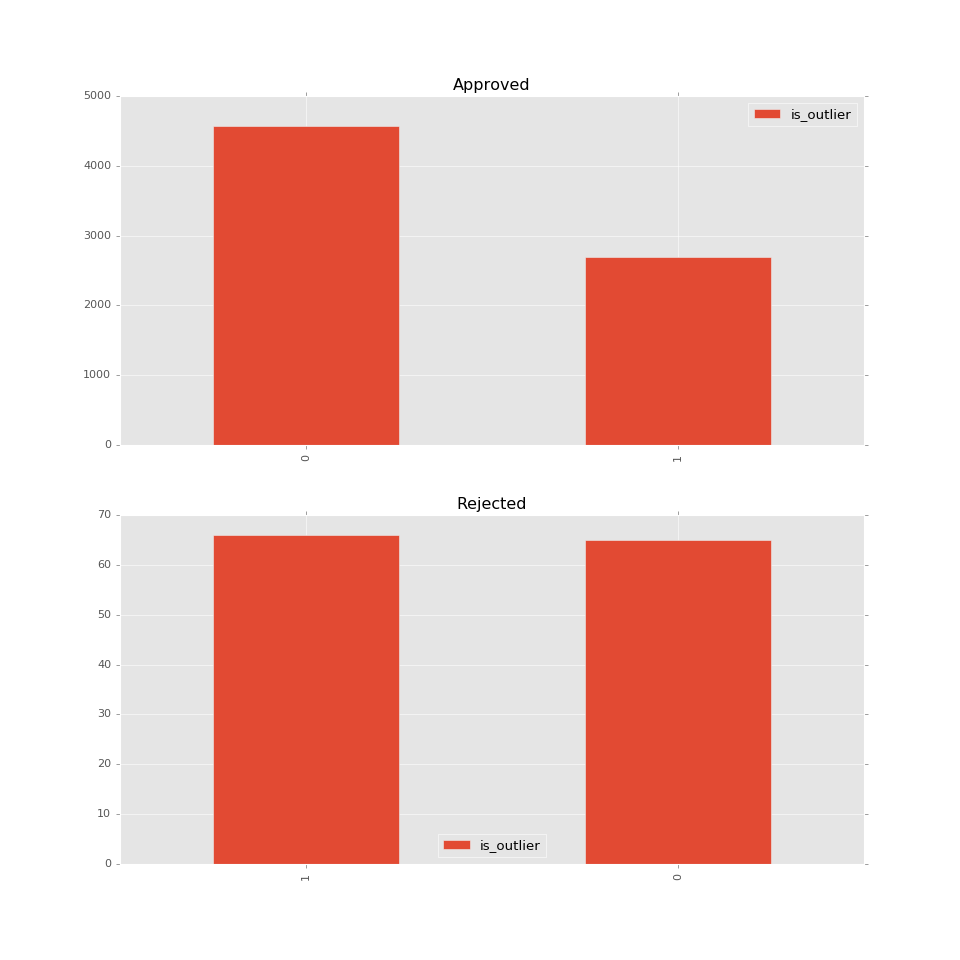

In [94]:
visualize_non_numeric_feature_distriution(df, 'is_outlier') 

In [88]:
# Normalize numeric features btw -0.5 and 0.5
NUMERIC_FEATURES = [
    'amount',
    'payments_out_amount_average',
    'payments_out_amount_total',
    'payments_out_count',
    'payments_out_std_dev',
    'uploads_amount_average',
    'uploads_amount_total',
    'uploads_count',
    'uploads_std_dev',
    'diff_to_avg_amount',
    'difference_btw_incoming_and_outcoming_payments_number',
    'difference_btw_incoming_and_outcoming_payments_volume']

def normalize_feature(df, feature):
    """
    Scale feature btw -0.5 and 0.5
    """
    min_value = df[feature].min()
    max_value = df[feature].max()
    return df[feature].map(lambda x: float(x - min_value) / (max_value - min_value) - 0.5)

for feature in NUMERIC_FEATURES:
    df[feature] = normalize_feature(df, feature)
    
df.describe()

,amount,payments_out_amount_average,payments_out_amount_total,payments_out_count,payments_out_std_dev,uploads_amount_average,uploads_amount_total,uploads_count,uploads_std_dev,registration_ip_mathes_domicile,is_approved,is_outbound,diff_to_avg_amount,is_outlier,differents_btw_incoming_and_outcoming_payments_number,differents_btw_incoming_and_outcoming_payments_volume,difference_btw_incoming_and_outcoming_payments_number,difference_btw_incoming_and_outcoming_payments_volume
count,7384.000000,7384.000000,7384.000000,7384.000000,7384.000000,7384.000000,7384.000000,7384.000000,7384.000000,7384.000000,7384.000000,7384.000000,7384.000000,7384.000000,7384.000000,7.384000e+03,7384.000000,7384.000000
mean,-0.487846,-0.469550,-0.485610,-0.418703,-0.477709,-0.482292,-0.483208,-0.491803,-0.469280,0.938109,0.982259,0.665628,-0.261608,0.373104,-40.800650,-7.488910e+04,-0.384450,0.471919
std,0.039634,0.050027,0.038438,0.120775,0.042119,0.042203,0.044119,0.020361,0.062012,0.240973,0.132018,0.471802,0.028864,0.483662,331.678427,2.035212e+05,0.020297,0.037667
min,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,0.000000,0.000000,0.000000,-0.500000,0.000000,-1929.000000,-5.326378e+06,-0.500000,-0.500000
25%,-0.499186,-0.493013,-0.499172,-0.488832,-0.495604,-0.498280,-0.498763,-0.499245,-0.496993,1.000000,1.000000,0.000000,-0.266456,0.000000,-96.000000,-6.188431e+04,-0.387828,0.474326
50%,-0.497231,-0.483816,-0.496851,-0.464975,-0.489535,-0.495001,-0.495797,-0.497528,-0.489444,1.000000,1.000000,1.000000,-0.264470,0.000000,-17.000000,-1.549957e+04,-0.382994,0.482911
75%,-0.491106,-0.465082,-0.487979,-0.398477,-0.477598,-0.482360,-0.486160,-0.492446,-0.467602,1.000000,1.000000,1.000000,-0.261906,1.000000,9.000000,-3.679507e+03,-0.381403,0.485099
max,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,1.000000,1.000000,1.000000,0.500000,1.000000,14412.000000,7.683600e+04,0.500000,0.500000


<IPython.core.display.Javascript object>


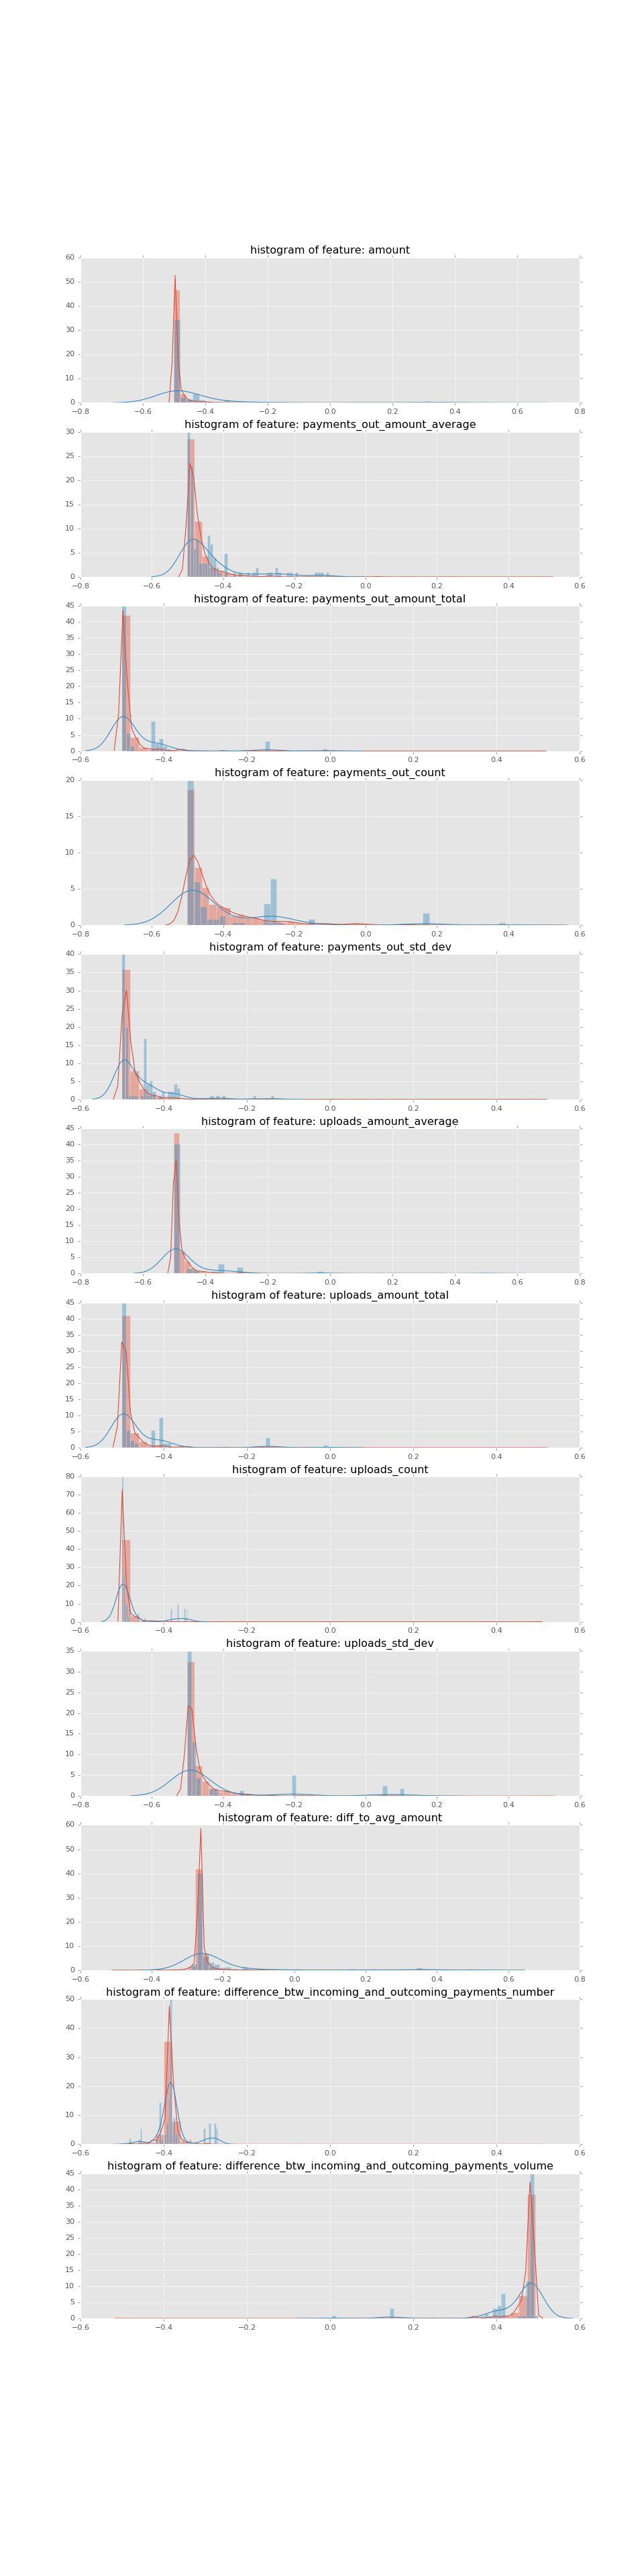

In [92]:
# Plot histograms for numeric features
import seaborn as sns
import matplotlib.gridspec as gridspec


NUMERIC_FEATURES_NUMBER = len(NUMERIC_FEATURES)


plt.figure(figsize=(12, NUMERIC_FEATURES_NUMBER * 4))
gs = gridspec.GridSpec(NUMERIC_FEATURES_NUMBER, 1)
for i, feature in enumerate(df[NUMERIC_FEATURES]):
    ax = plt.subplot(gs[i])
    sns.distplot(df[feature][df.is_approved == 1], bins=50)
    sns.distplot(df[feature][df.is_approved == 0], bins=50)
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(feature))
plt.show()

In [118]:
# Ouch: all features look quite similar
# Ok, let's use all of them
FEATURE_SET = NUMERIC_FEATURES + ['registration_ip_mathes_domicile', 'is_outbound', 'is_outlier']

In [119]:
# Once again make sure that all features are float
for feature in FEATURE_SET:
    df[feature] = pd.to_numeric(df[feature])

In [135]:
# Add target value
df['risk'] = df.is_approved.map(lambda x: (1 - x) )

In [136]:
# Split datasets to train and test
train_df = pd.concat(
    (
        df[df.is_approved == 0].sample(frac=0.7),
        df[df.is_approved == 1].sample(frac=0.7),
    ),
    axis=0)
test_df = df.loc[~df.index.isin(train_df.index)]

In [137]:
# Shuffle datasets
from sklearn.utils import shuffle
train_df = shuffle(train_df)
test_df = shuffle(test_df)

In [141]:
# Split datasets to X and y
X_train_df = train_df[FEAUTURE_SET]
X_test_df = test_df[FEAUTURE_SET]
y_train_df = train_df[['risk', 'is_approved']]
y_test_df = test_df[['risk', 'is_approved']]

In [142]:
# Train the neural network

input_x = X_train_df.as_matrix()
input_y = y_train_df.as_matrix()

# split test dataset to validation and test datasets
split = int(len(y_test_df)/2)
input_x_valid = X_test_df.as_matrix()[:split]
input_y_valid = y_test_df.as_matrix()[:split]
input_x_test = X_test_df.as_matrix()[split:]
input_y_test = y_test_df.as_matrix()[split:]

In [143]:
# Build tensorflow graph for simple fully connected network
import tensorflow as tf

batch_size = 256
features_size = len(FEAUTURE_SET)
num_labels = 2

graph = tf.Graph()
with graph.as_default():
    tf_train_dataset = tf.placeholder(
        tf.float64,
        shape=(batch_size, features_size))
    tf_train_labels = tf.placeholder(tf.float64, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(input_x_valid)
    tf_test_dataset = tf.constant(input_x_test)
  
    # Variables.
    weights = tf.Variable(
        tf.truncated_normal([features_size, num_labels], dtype=tf.float64))
    biases = tf.Variable(tf.zeros([num_labels], dtype=tf.float64))
    
    
    logits = tf.nn.xw_plus_b(tf_train_dataset, weights, biases)
    loss = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
        labels=tf_train_labels, logits=logits))
  
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(
        tf.nn.xw_plus_b(
            tf_valid_dataset, weights, biases))
    test_prediction = tf.nn.softmax(    
        tf.nn.xw_plus_b(
            tf_test_dataset, weights, biases))


In [153]:
import numpy as np
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

num_steps = 39

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    for step in range(num_steps):
        offset = (step * batch_size) % (input_y.shape[0] - batch_size)
        batch_data = input_x[offset:(offset + batch_size), :]
        batch_labels = input_y[offset:(offset + batch_size), :]

        feed_dict = {
            tf_train_dataset : batch_data, 
            tf_train_labels : batch_labels
        }
        _, l, predictions = session.run(
           [optimizer, loss, train_prediction], 
           feed_dict=feed_dict)
        print("Minibatch loss at step %d: %f" % (step, l))
        print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
        print("Validation accuracy: %.1f%%" % accuracy(
            valid_prediction.eval(), input_y_valid))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), input_y_test))
    # Hmm nice prediction. Wondering if any risk payments were detected?
    prediction = test_prediction.eval()
    print(
        'Risky transaction', 
        sum(np.argmax(predictions, 1) == 0)) # first column encodes risk (0 - column number)
    print(
        'Approved transactions',
        sum(np.argmax(predictions, 1) == 1)) # second column encodes approved payments (1 - column number)

Minibatch loss at step 0: 0.147554
Minibatch accuracy: 98.4%
Validation accuracy: 99.7%
Minibatch loss at step 1: 0.101399
Minibatch accuracy: 99.6%
Validation accuracy: 99.7%
Minibatch loss at step 2: 0.132636
Minibatch accuracy: 98.0%
Validation accuracy: 99.7%
Minibatch loss at step 3: 0.153788
Minibatch accuracy: 97.7%
Validation accuracy: 99.7%
Minibatch loss at step 4: 0.133564
Minibatch accuracy: 98.0%
Validation accuracy: 99.7%
Minibatch loss at step 5: 0.127419
Minibatch accuracy: 98.0%
Validation accuracy: 99.7%
Minibatch loss at step 6: 0.088967
Minibatch accuracy: 98.8%
Validation accuracy: 99.7%
Minibatch loss at step 7: 0.105377
Minibatch accuracy: 98.4%
Validation accuracy: 99.7%
Minibatch loss at step 8: 0.192010
Minibatch accuracy: 96.5%
Validation accuracy: 99.7%
Minibatch loss at step 9: 0.106670
Minibatch accuracy: 98.4%
Validation accuracy: 99.7%
Minibatch loss at step 10: 0.061555
Minibatch accuracy: 99.2%
Validation accuracy: 99.7%
Minibatch loss at step 11: 0.02

In [175]:
# Oh no, looks like our nn is just mark every transaction as approved
# No surprise with such unbalanced dataset
# Let's try to fix situation by adding weight to risk column

# Train the neural network

input_x = X_train_df.as_matrix()
input_y = y_train_df.as_matrix()

# split test dataset to validation and test datasets
split = int(len(y_test_df)/2)
input_x_valid = X_test_df.as_matrix()[:split]
input_y_valid = y_test_df.as_matrix()[:split]
input_x_test = X_test_df.as_matrix()[split:]
input_y_test = y_test_df.as_matrix()[split:]


ratio = len(df) / len(df[df.is_approved == 0])
def multiply_first_element_by_ratio(x):
    #print(x[0], x[1])
    return  [x[0] * ratio, x[1]]

input_y = np.array(map(multiply_first_element_by_ratio, input_y))
input_y_valid = np.array(map(multiply_first_element_by_ratio, input_y_test))
input_y_test = np.array(map(multiply_first_element_by_ratio, input_y_test))

In [176]:
# TODO: fix awfull accuracy
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    for step in range(num_steps):
        offset = (step * batch_size) % (input_y.shape[0] - batch_size)
        batch_data = input_x[offset:(offset + batch_size), :]
        batch_labels = input_y[offset:(offset + batch_size), :]

        feed_dict = {
            tf_train_dataset : batch_data, 
            tf_train_labels : batch_labels
        }
        _, l, predictions = session.run(
           [optimizer, loss, train_prediction], 
           feed_dict=feed_dict)
        print("Minibatch loss at step %d: %f" % (step, l))
        print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
        print("Validation accuracy: %.1f%%" % accuracy(
            valid_prediction.eval(), input_y_valid))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), input_y_test))
    print(
        'Risky transaction', 
        sum(np.argmax(predictions, 1) == 0)) # first column encodes risk (0 - column number)
    print(
        'Approved transactions',
        sum(np.argmax(predictions, 1) == 1)) # second column encodes approved payments (1 - column number)

Minibatch loss at step 0: 0.873716
Minibatch accuracy: 62.9%
Validation accuracy: 57.4%
Minibatch loss at step 1: 0.583139
Minibatch accuracy: 64.1%
Validation accuracy: 96.7%
Minibatch loss at step 2: 1.256861
Minibatch accuracy: 96.1%
Validation accuracy: 58.0%
Minibatch loss at step 3: 0.713039
Minibatch accuracy: 61.7%
Validation accuracy: 57.0%
Minibatch loss at step 4: 1.034619
Minibatch accuracy: 65.2%
Validation accuracy: 57.0%
Minibatch loss at step 5: 0.876246
Minibatch accuracy: 64.5%
Validation accuracy: 57.2%
Minibatch loss at step 6: 0.915696
Minibatch accuracy: 62.1%
Validation accuracy: 69.6%
Minibatch loss at step 7: 0.428961
Minibatch accuracy: 74.6%
Validation accuracy: 58.6%
Minibatch loss at step 8: 0.728783
Minibatch accuracy: 55.1%
Validation accuracy: 21.6%
Minibatch loss at step 9: 1.879009
Minibatch accuracy: 21.5%
Validation accuracy: 58.4%
Minibatch loss at step 10: 0.919631
Minibatch accuracy: 54.7%
Validation accuracy: 95.4%
Minibatch loss at step 11: 0.37